## Lade Pakete

In [45]:
import os # um Pfad anzulegen oder zu ändern
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import lightgbm as lgb

#sklearn Pakete
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, average_precision_score, recall_score, precision_score, precision_recall_curve, f1_score, classification_report, roc_auc_score, roc_curve
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer # ersetzen von fehlenden Werten
from sklearn.compose import ColumnTransformer
from scipy.stats import ttest_ind
from lightgbm import LGBMClassifier
from scipy.stats import randint, uniform
from sklearn.utils.class_weight import compute_class_weight

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE, BorderlineSMOTE # Oversampling
from imblearn.under_sampling import RandomUnderSampler # Undersampling
from imblearn.pipeline import Pipeline # spezielle Pipeline für SMOTE nötig

import xgboost as xgb

# statsmodel Pakete
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Pfadeingabe

In [4]:
# Pfad zum lokalen Speicherort der Daten, r davor einfügen damit spezielle Zeichen auch als String erkannt werden
data_dir = r"C:\Users\MLA6FE\Desktop\Data_Science_Project\data"
file_path = os.path.join(data_dir, "bankaccounts.csv")

## CSV-Daten in data frame laden

In [5]:
df_bankaccounts = pd.read_csv(file_path)

## Überblick über Daten verschaffen

In [ ]:
#df_bankaccounts.head() # erste 5 Zeilen des Datensatzes
#df.shape               # Anzahl der Zeilen und Spalten
#df.columns             # Spaltennamen
df_bankaccounts.info()  # Spaltennamen, 0-Werte, Datentypen

In [ ]:
# Datensatz auf Duplikate überprüfen

#df_bankaccounts[df_bankaccounts.duplicated()] # zeigt ganze Zeilen mit den Duplikaten an
df_bankaccounts.duplicated().sum() # gibt Summe der doppelten Zeilen an

## Nicht benötigte Spalten löschen und unter X (unabhängige Variablen) und y (abhängige Variable) speichern

In [6]:
X = df_bankaccounts.drop(axis = 1, columns = ["x1", "x2", "fraud_bool"]) # löscht die gewünschten Spalten aus data frame
y = df_bankaccounts["fraud_bool"] # erzeugt data frame y mit gewünschter Spalte
X.shape, y.shape # gibt die Form der data frames aus

((1000000, 31), (1000000,))

In [ ]:
# Darstellen aller Daten
# Anzahl der Spalten
cols = X.columns
n_cols = 4  # Spalten pro Reihe
n_rows = math.ceil(len(cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()  # 2D-Array in 1D für einfaches Iterieren

for i, col in enumerate(cols):
    ax = axes[i]
    
    # Kategoriale Features
    if X[col].dtype == 'object' or X[col].nunique() < 20:
        sns.countplot(x=col, data=X, order=X[col].value_counts().index, ax=ax)
        ax.set_title(f'{col} (kategorial)')
        ax.tick_params(axis="x", rotation=45)

    # Numerische Features
    else:
        sns.histplot(X[col], bins=20, kde=False, ax=ax)
        ax.set_title(f'{col} (numerisch)')

# Leere Achsen ausblenden
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Häufigkeit der Werte der Zielgröße über alle Features

In [ ]:
# Definiere style für alle folgenden plots
plt.style.use('bmh')

fraud_or_not = y.value_counts(normalize=True).sort_index() * 100 # zählt alle Häufigkeiten je Kategortie und sortiert es nach aufsteigendem index
# normalisiert die Werte und multipliziert sie mit 100 für eine prozentuale Darstellung

# gibt Tabelle aus mit prozentualer Verteilung
print("Prozentuale Verteilung:", fraud_or_not)

#erstellt barplot
fraud_or_not.plot(kind="bar", color="skyblue")
plt.ylabel("Anteil (%)")
plt.xlabel("Betrugsfall oder nicht")
plt.title("Betrugsquote")
plt.xticks(rotation=0) # damit Zahlen nicht gedreht werden

plt.tight_layout()  # saubere Darstellung
plt.show()

In [ ]:
# Schleife, welche über alle features des Datensatzes X geht und die prozentuale Darstellung für y 0 und 1 ausgibt
for feature in X:
    print(f"\n Verteilung von y nach {feature}:")
    display(pd.crosstab(X[feature], y, normalize='index') * 100)

## Verteilung der geschützten Attribute in Barplots

In [ ]:
# Suplots anlegen
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# income
X["income"].value_counts().sort_index().plot(kind="bar", color="skyblue", ax=axes[0]) # zählt alle Häufigkeiten je Kategortie und sortiert es nach aufsteigendem index
axes[0].set_title("Verteilung Einkommen")
axes[0].set_xlabel("Einkommenskategorie")
axes[0].set_ylabel("Häufigkeit")

#costumer age
X["customer_age"].value_counts().sort_index().plot(kind="bar", color="lightgreen", ax=axes[1])
axes[1].set_title("Verteilung Alter")
axes[1].set_xlabel("Alter")

#employment status
X["employment_status"].value_counts().sort_index().plot(kind="bar", color="purple", ax=axes[2])
axes[2].set_title("Verteilung Angestellte")
axes[2].set_xlabel("Angestelltenverhältnis")

plt.tight_layout()  # saubere Darstellung
plt.show()

## Häufigkeit der Zielgröße bei den geschützten Attributen

In [ ]:
# erstelle crosstabs, Kreuztabellen wie oft jede Kombination mit 0, 1 vorkommt
crosstab_income = pd.crosstab(X["income"], y, normalize='index') * 100
crosstab_costumer_age = pd.crosstab(X["customer_age"], y, normalize='index') * 100
crosstab_employment_status = pd.crosstab(X["employment_status"], y, normalize='index') * 100

# Tabelle mit den Prozentwerten ausgeben
print(crosstab_income)
print(crosstab_costumer_age)
print(crosstab_employment_status)

# Suplots anlegen
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# income
crosstab_income.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], ax=axes[0])
axes[0].set_title("fraud_bool beim Einkommen")
axes[0].set_xlabel("Einkommenskategorie")
axes[0].set_ylabel("Anzahl")

#costumer age
crosstab_costumer_age.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], ax=axes[1])
axes[1].set_title("fraud_bool beim Alter")
axes[1].set_xlabel("Alter")

#employment status
crosstab_employment_status.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], ax=axes[2])
axes[2].set_title("fraud_bool bei den Angestellten")
axes[2].set_xlabel("Angestelltenverhältnis")

plt.tight_layout()  # saubere Darstellung
plt.show()

## Datensatz nach fehlenden Werten untersuchen

In [143]:
# gibt für jede Spalte die Summe der fehlende Werte aus
print(X.isna().sum())
print(y.isna().sum())
# keine 0-Werte enthalten

income                                   0
name_email_similarity                    0
current_address_months_count          3473
customer_age                             0
days_since_request                       0
payment_type                             0
zip_count_4w                             0
velocity_6h                              0
velocity_24h                             0
velocity_4w                              0
bank_branch_count_8w                     0
date_of_birth_distinct_emails_4w         0
employment_status                        0
credit_risk_score                        0
email_is_free                            0
housing_status                           0
phone_home_valid                         0
phone_mobile_valid                       0
bank_months_count                   247242
has_other_cards                          0
proposed_credit_limit                    0
foreign_request                          0
source                                   0
session_len

In [7]:
# Alle Spalten mit fehlenden Werten manuell erfassen
missing_values = ["prev_address_months_count", 
                  "current_address_months_count", 
                  "bank_months_count", 
                  "session_length_in_minutes",
                  "session_length_in_minutes", 
                  "device_distinct_emails_8w",
                 "intended_balcon_amount"]

# iteriert über alle Spalten des DataFrames X
for col in X.columns:
    if col in missing_values: # schaut nach den Spalten mit missing values
        if (X[col] < 0).any(): # schaut nach den Werten dieser Spalten kleiner 0
            missing = (X[col] < 0).sum() # gibt die Summe der missing values also kleiner 0 aus
            print(f"{col}: {missing}") # gibt diese aus
            X[col] = X[col].apply(lambda x: np.nan if x < 0 else x) # ersetzt die fehlenden Werte druch np.nan zur besseren Weiterverarbeitung

prev_address_months_count: 762005
current_address_months_count: 3473
intended_balcon_amount: 751724
bank_months_count: 247242
session_length_in_minutes: 2256
device_distinct_emails_8w: 332


In [8]:
X = X.drop(axis = 1, columns = ["prev_address_months_count", "intended_balcon_amount"]) # Entferne Spalten/Features mit über 50% fehlenden Werten

imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=50, random_state=42), random_state=42)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [9]:
# Fehlende Werte ersetzen (-1 Werte in diesem Fall)
# -1 Werte als NaN markieren
X['current_address_months_count'] = X['current_address_months_count'].replace(-1, np.nan)
X["bank_months_count"] = X["bank_months_count"].replace(-1, np.nan)
X["session_length_in_minutes"] = X["session_length_in_minutes"].replace(-1, np.nan)
X["device_distinct_emails_8w"] = X["device_distinct_emails_8w"].replace(-1, np.nan)

# Mean Imputer erstellen
imputer = SimpleImputer(strategy='median')

# Spalten imputen mit Durchschnittswert der jeweiligen Spalte
X['current_address_months_count'] = imputer.fit_transform(X[['current_address_months_count']])
X["bank_months_count"] = imputer.fit_transform(X[["bank_months_count"]])
X["session_length_in_minutes"] = imputer.fit_transform(X[["session_length_in_minutes"]])
X["device_distinct_emails_8w"] = imputer.fit_transform(X[["device_distinct_emails_8w"]])

In [ ]:
#display(pd.crosstab(X["bank_months_count"], y, normalize='index') * 100) #bei -1 sind es 1.711279% Betrugsfälle, wichtig fürs Modell

## Kategoriale Spalten durch Dummies ersetzen mit Label Encoding und OneHot Encoding

In [13]:
def data_dummy_encoding(X, encoder):
    """
    Wendet auf alle object-Spalten entweder LabelEncoding oder OneHotEncoding an.
    
    Parameter:
        X (DataFrame): Eingabedaten
        encoder (str): "label" oder "onehot"
    """
    
    X = X.copy()  # Original nicht überschreiben

    manuell_encoding = ["income", "customer_age", "month"]
    
    # Label Encoding - Umwandlung einer Spalte in 0, 1, 2, 3, etc. 
    if encoder == "label":
        
        le = LabelEncoder()
        for col in X.columns:
            if X[col].dtype == "object" or col in manuell_encoding: # encoded alle Spalten vom Datentyp object oder wenn vorhanden manuell definierte Spalten
                print(f"Label-Encoding für: {col}")
                X[col] = le.fit_transform(X[col].astype(str)) # astype(str) wandelt alle Werte in Strings um falls eine Spalte mehrere Typen hat
                # fit_transform lernt und transformiert, welche Kategorien es gibt ("rot", "blau", "grün") und wandelt sie in Zahlen um (z. B. 0, 1, 2)
    
    # OneHot Encoding - Umwandlung einer Spalte in mehrere binäre Spalten 0/1
    elif encoder == "onehot":
        
        for col in manuell_encoding: # zuerst manuell zu encodede numerische Spalten encoden, falls vorhanden
            if col in X.columns:
                print(f"OneHot-Encoding (manuell) für: {col}")
                dummies = pd.get_dummies(X[col], prefix=col, drop_first=True).astype(int) # prefix = col alle neuen Dummy-Spalten bekommen den Spaltennamen als Präfix, jeder Wert der kategorialen Spalte bekommt eigene neue Spalte
                # überlegen ob drop_first = True, um Multikollinearität zu vermeiden...zum Beispiel alle Werte = 1 - bei True entfernt es die erste binäre Spalte
                dummies = dummies.astype(int) # durch .astype(int) werden die erzeugten boolschen Werte True und False in 0 und 1 umgewandelt für die bessere Weiterverarveitung
                X = X.drop(columns=[col]) # entfernt ursprüngliche zu ersetzende Spalte
                X = pd.concat([X, dummies], axis=1) # concat nimmt beide DataFrames und fügt sie spaltenweise zusammen, die dummie-Spalten kommen an das Ende des DtaaFrames
        
        for col in X.select_dtypes(include=['object']).columns:
            print(f"OneHot-Encoding für: {col}")
            dummies = pd.get_dummies(X[col], prefix=col, drop_first=True) # prefix = col alle neuen Dummy-Spalten bekommen den Spaltennamen als Präfix, jeder Wert der kategorialen Spalte bekommt eigene neue Spalte
            # überlegen ob drop_first = True, um Multikollinearität zu vermeiden...zum Beispiel alle Werte = 1 - bei True entfernt es die erste binäre Spalte
            dummies = dummies.astype(int) # durch .astype(int) werden die erzeugten boolschen Werte True und False in 0 und 1 umgewandelt für die bessere Weiterverarveitung
            X = X.drop(columns=[col]) # entfernt ursprüngliche zu ersetzende Spalte
            X = pd.concat([X, dummies], axis=1) # concat nimmt beide DataFrames und fügt sie spaltenweise zusammen, die dummie-Spalten kommen an das Ende des DtaaFrames
    
    else:
        raise ValueError("encoder muss 'label' oder 'onehot' sein.")
    
    return X

In [14]:
X = data_dummy_encoding(X, "onehot") # Optionen: LabelEncoder() = "label" OneHotEncoder() = "onehot"

OneHot-Encoding (force) für: income
OneHot-Encoding (force) für: customer_age
OneHot-Encoding (force) für: month
OneHot-Encoding für: payment_type
OneHot-Encoding für: employment_status
OneHot-Encoding für: housing_status
OneHot-Encoding für: source
OneHot-Encoding für: device_os


In [15]:
# Datentypen checken, ob Umwandlung funktioniert hat
X.dtypes

name_email_similarity           float64
current_address_months_count    float64
days_since_request              float64
zip_count_4w                      int64
velocity_6h                     float64
                                 ...   
source_TELEAPP                    int32
device_os_macintosh               int32
device_os_other                   int32
device_os_windows                 int32
device_os_x11                     int32
Length: 65, dtype: object

## Logistische Regression

Vorgehensweise

1. Prüfen, ob Zielvariable binär ist (0 / 1) --> schon erledigt, passt
2. Duplikate immer löschen...machen das Modell schlechter!
3. Prüfen der Verteilung von y (Zielvariable) --> schon erledigt, Modell stark unausgeglichen mit 0: 98,89 %
   Hohe Accuracy bei der Betrachtung nicht alleine ausreichend (Modell könnte immer 0 vorraussagen für eine hohe Accuracy) --> Betrugsfälle werden nicht ausreichend erfasst
   Lösung: z. B. LogisticRegression(class_weight = "balanced") gewichtet seltene Klasse stärker und häufige Klasse geringer, 
   Oversampling der Minderheitsklasse durch erzeugen von mehr Beispielen, 
   Undersampling der Mehrheitsklasse(schlecht, Daten gehen verloren)
4. Datentypen der Feature prüfen und kategorische Feature in Dummies (0 / 1) oder mehr Zahlen umwandeln. Bei OneHotEncoding() drop_first = True evtl. sinnvoll um Multikollinearität zu vermeiden...
   zum Beispiel alle Werte = 1, entfernt dann die     erste binäre Spalte
5. Datensatz nach fehlenden Werten untersuchen und Zeilen/Spalten löschen oder auffüllen mit z. b. Durchschnittswert --> schon erledigt
6. Skalierung (nicht immer nötig), bringt alle numerischen Feature auf eine ähnliche Skala, unterschiedliche Skalen verzerren die Gewichtungen.
   Bei der lodistischen Regression ist das nicht unbedingt notwendig aber wenn mit Regularisierung (Strafterme) zwingedn erforderlich
7. Auf perfekte oder starke Korrelationen prüfen wegen Multikollinearität (Features enthalten fast gleiche Informationen, führt z. B. zu instabiler Gewichtung) --> erst nach Dummieumwandlung, bei kategorialen Features nicht möglich
   Korrelation berechnen und darstellen mit z. b. Heatmap
   Obere Dreiecksmatrix auswählen...reicht aus, da untere Dreiecksmatrix die gleiche Berechnung macht nur die Features sind auf der x- und y-Achse vertauscht. Spart Rechenzeit
   Stark korrelierte Features identifizieren, Schwellenwert setzen welche Feature bei welcher Korrelation entfernt werden sollen, z. B. größer gleich 0,9 für starke Korrelation
   Die Feature mit hoher Korrelation entfernen
   Nochmal diesen Schritt durchführen, ob es besser geworden ist: Korrelation berechnen und darstellen mit z. b. Heatmap
   Skalierung vorher nicht unbedingt nötig
   corr (in Python ist damit standardmäßig die Pearson Korrelation gemeint) und VIF geht nur zuverlässig mit linearen Beziehungen zwischen Features!
8. Feature auf Varianz untersuchen, misst, die stark sich die Werte eines Merkmals unterscheiden. Ein feature das fast nur die gleichen Werte z. b. immer nur 1 oder 0 hat bringt keine 
   Informationen für das Modell (bringt mathematische Probleme bei nur 0-Werten und unnötigen Rechenaufwand mit sich)
   Manuell prüfen oder mit VarianceThreshold von sklearn (damit werden Spalten mit vorgegebener Varianz aufomatisch entfernt)
   0.01 = 1% Varianz, bedeutet es werden alle Spalten entfernt, bei denen eine Klasse 99% vorkommt
   Man muss hier auch Unterscheiden, für Dummie Feature nimmt man hier eher höhere Werte als für kontinuierliche Feature mit mehr Werten
   Skalierung vorher zwingend nötig, da Varianz stark skalenabhängig
9. Prüfen auf Anzahl der Feature und Beobachtungen, Faustregel: Mindestend 10-20 Beobachtungen pro Feature --> locker erfüllt

## Skalierung durchführen von bestimmten Spalten, Spalten die sich schon zwischen 0 und 1 bewegen nicht mehr Skalieren

In [16]:
# Alle numerischen Spalten auswählen
numerische_Spalten = X.select_dtypes(include=['int', 'float']).columns

# Binäre Spalten identifizieren (mit 0 und 1)
binäre_Spalten = [col for col in numerische_Spalten if X[col].dropna().isin([0,1]).all()]

nicht_skalierte_Spalte = binäre_Spalten

print("Binäre Spalten:", binäre_Spalten)

skalierte_Spalten = []

# Spalten, die skaliert werden sollen durch Schleife auswählen
for col in X.columns:
    if col in nicht_skalierte_Spalte:
        pass
    else:
        skalierte_Spalten.append(col)

# Skalieren
scaler = MinMaxScaler()
#scaler = RobustScaler()
X = X.copy()
X[skalierte_Spalten] = scaler.fit_transform(X[skalierte_Spalten])

Binäre Spalten: ['email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'foreign_request', 'keep_alive_session', 'device_fraud_count', 'income_0.2', 'income_0.3', 'income_0.4', 'income_0.5', 'income_0.6000000000000001', 'income_0.7000000000000001', 'income_0.8', 'income_0.9', 'customer_age_20', 'customer_age_30', 'customer_age_40', 'customer_age_50', 'customer_age_60', 'customer_age_70', 'customer_age_80', 'customer_age_90', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'payment_type_AB', 'payment_type_AC', 'payment_type_AD', 'payment_type_AE', 'employment_status_CB', 'employment_status_CC', 'employment_status_CD', 'employment_status_CE', 'employment_status_CF', 'employment_status_CG', 'housing_status_BB', 'housing_status_BC', 'housing_status_BD', 'housing_status_BE', 'housing_status_BF', 'housing_status_BG', 'source_TELEAPP', 'device_os_macintosh', 'device_os_other', 'device_os_windows', 'device_os_x11']


## Korrelationen berechnen, Multikolinearität vermeiden und Features mit hoher Korrelation löschen

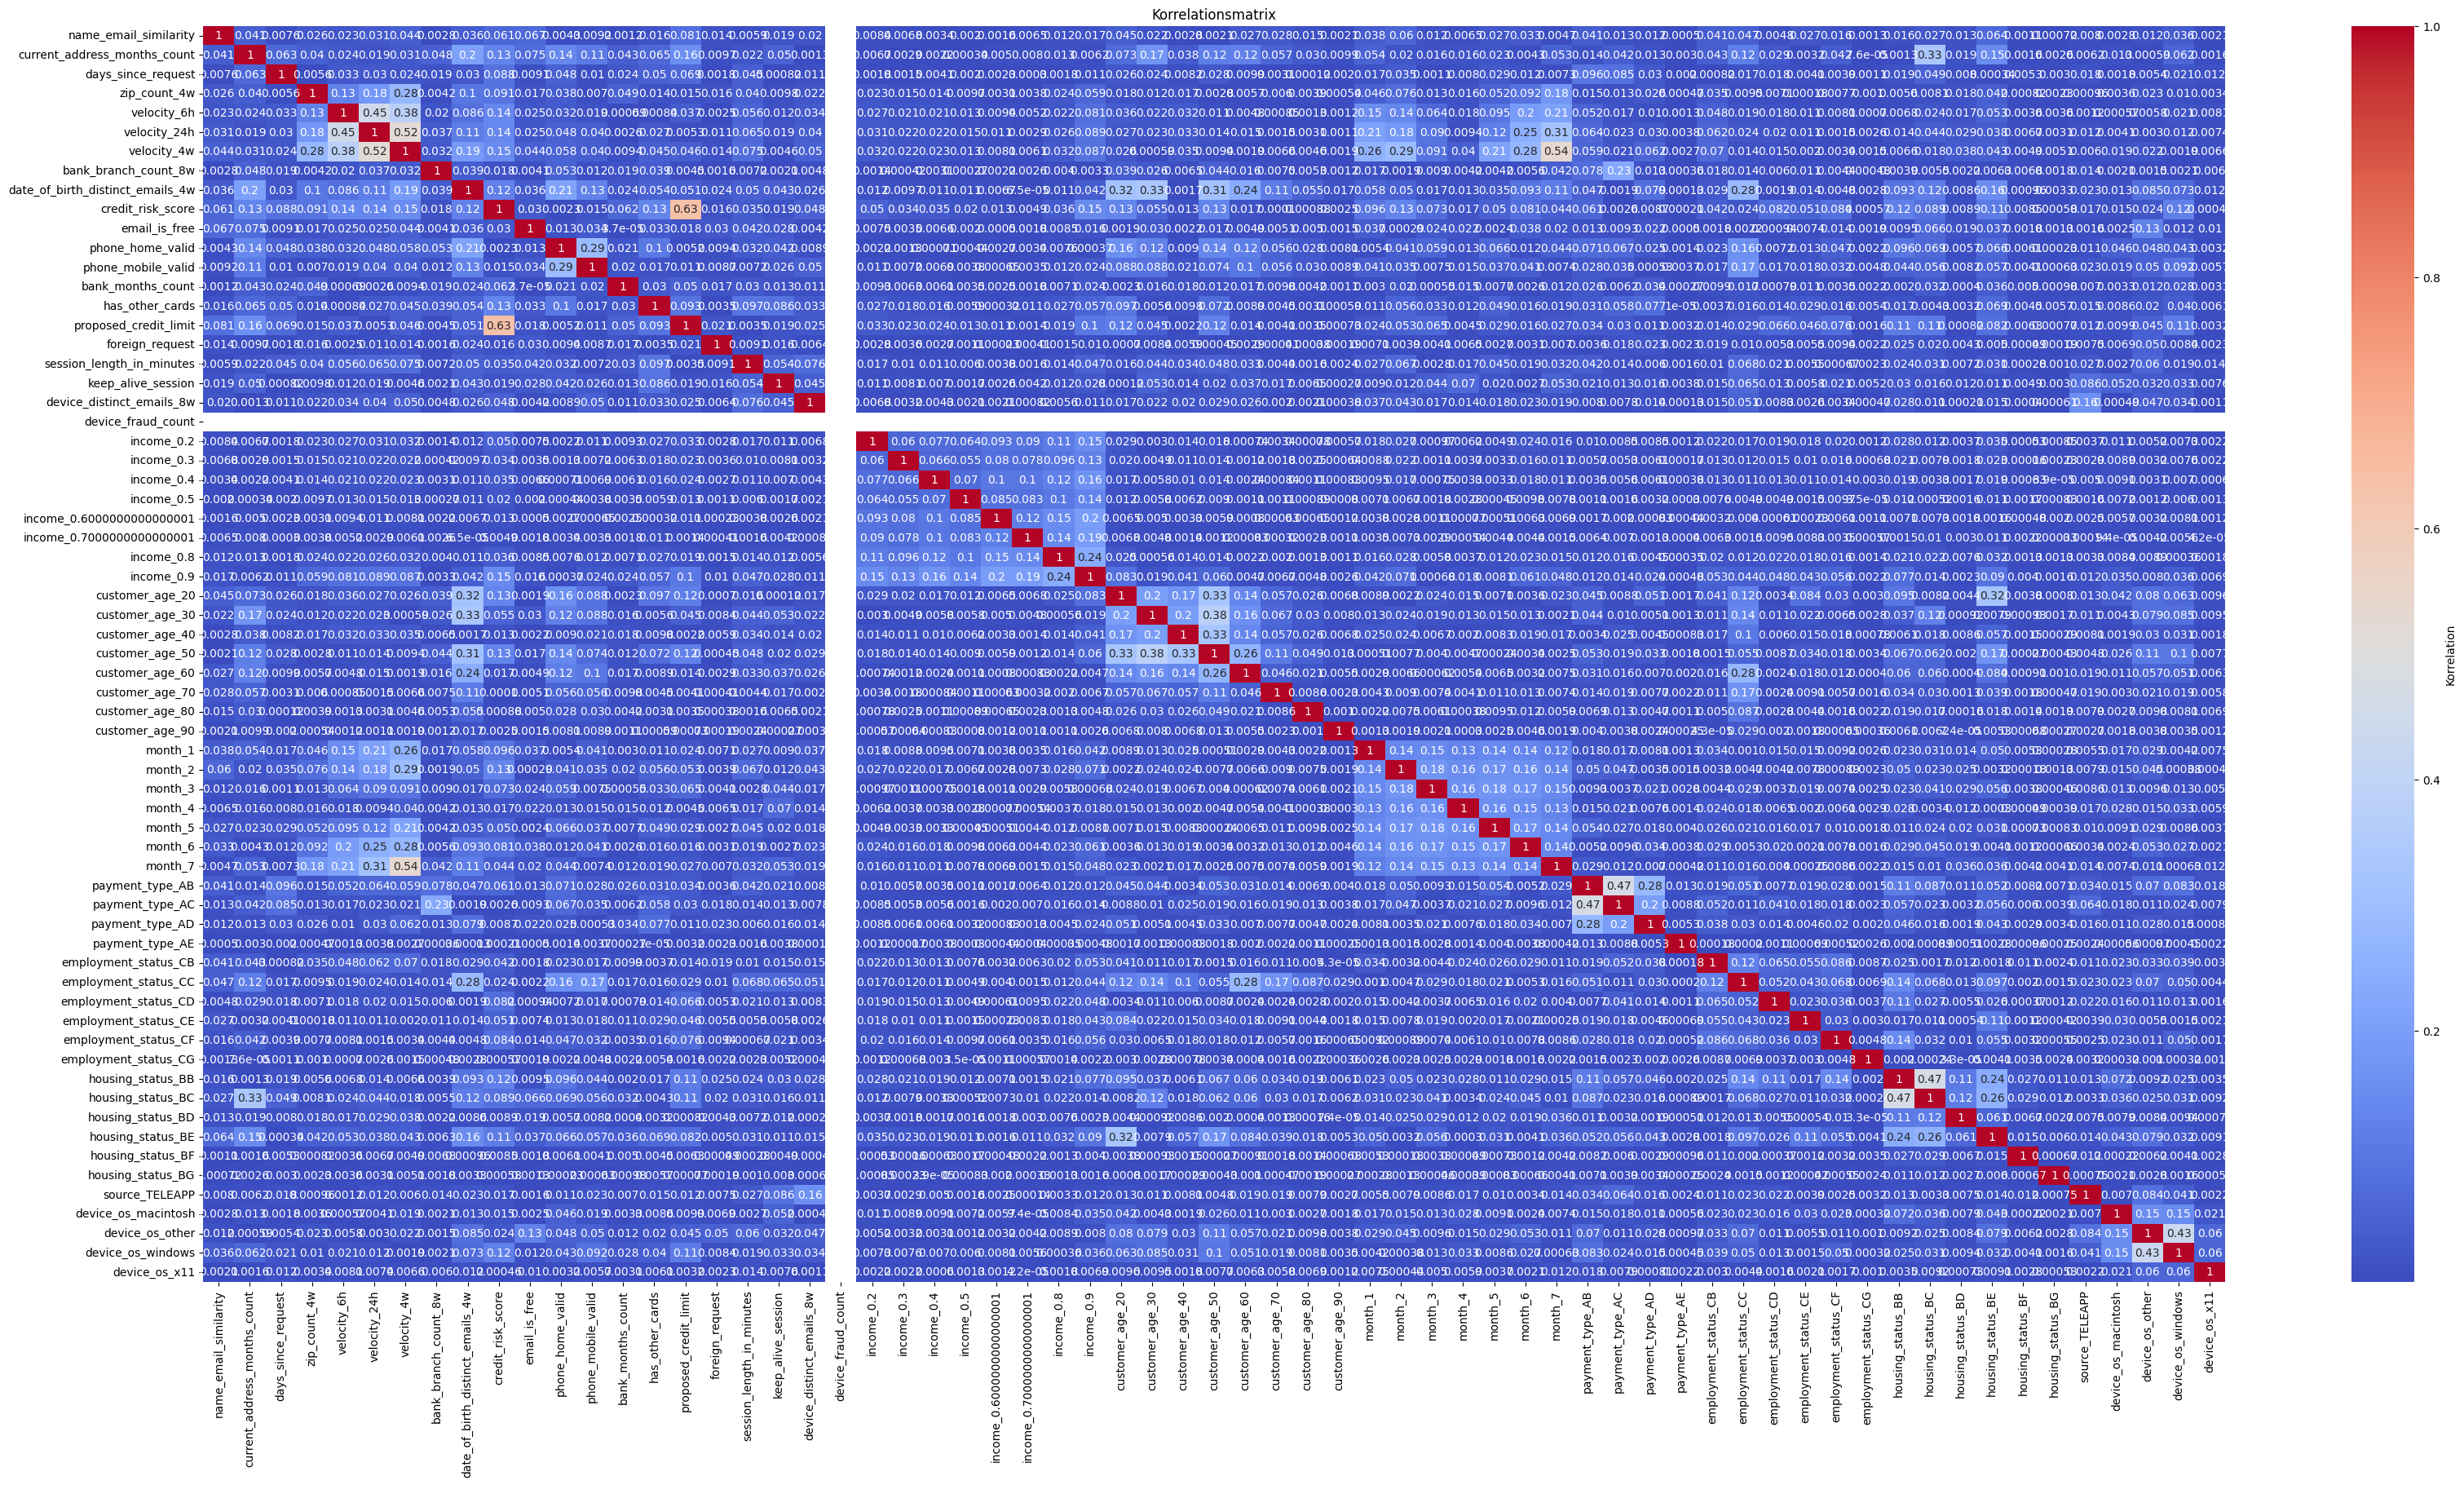

In [17]:
# Korrelation berechnen
corr_matrix = X.corr().abs() # abs() sehr wichtig, da auch Negativkorrelationen möglich sind und diese sonst nicht vom Threshold weiter unten erfasst werden

# Heatmap zur visuellen Kontrolle
plt.figure(figsize=(40, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, cbar_kws={'label': 'Korrelation'}) # annot = True schreibt Werte in die Kästchen, cbar_kws={'label': 'Korrelation'} labeled die Skala rechts
plt.title("Korrelationsmatrix")
plt.show()

In [18]:
# untere oder obere Dreiecksmatrix auswählen (in diesem Fall die untere)
untere = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))

# stark korrelierte Features identifizieren
threshold = 0.8 # Threshold  für Korrelation wählen...je näher an 1 desto höher
to_drop = [column for column in untere.columns if any(untere[column] > threshold)]
print("Features mit starker Korrelation über threshold:", to_drop)

Features mit starker Korrelation über threshold: []


In [19]:
# Features mit hoher Korrelation entfernen

X = X.drop(columns=to_drop)
print("Neue Form des DataFrames:", X.shape)

Neue Form des DataFrames: (1000000, 65)


In [ ]:
# Neue Korrelsationen nochmal prüfen
corr_matrix_reduced = X.corr().abs() # abs() sehr wichtig, da auch Negativkorrelationen möglich sind und diese sonst nicht vom Threshold weiter unten erfasst werden

# Heatmap zur visuellen Kontrolle
plt.figure(figsize=(40, 20))
sns.heatmap(corr_matrix_reduced, cmap='coolwarm', annot=True, cbar_kws={'label': 'Korrelation'})
plt.title("Korrelationsmatrix")
plt.show()

## Varianz berechnen und Features mit niedriger Varianz (viele gleiche Werte) entfernen, da kein Einfluss auf Modell und mehr Rechenleistung nötig

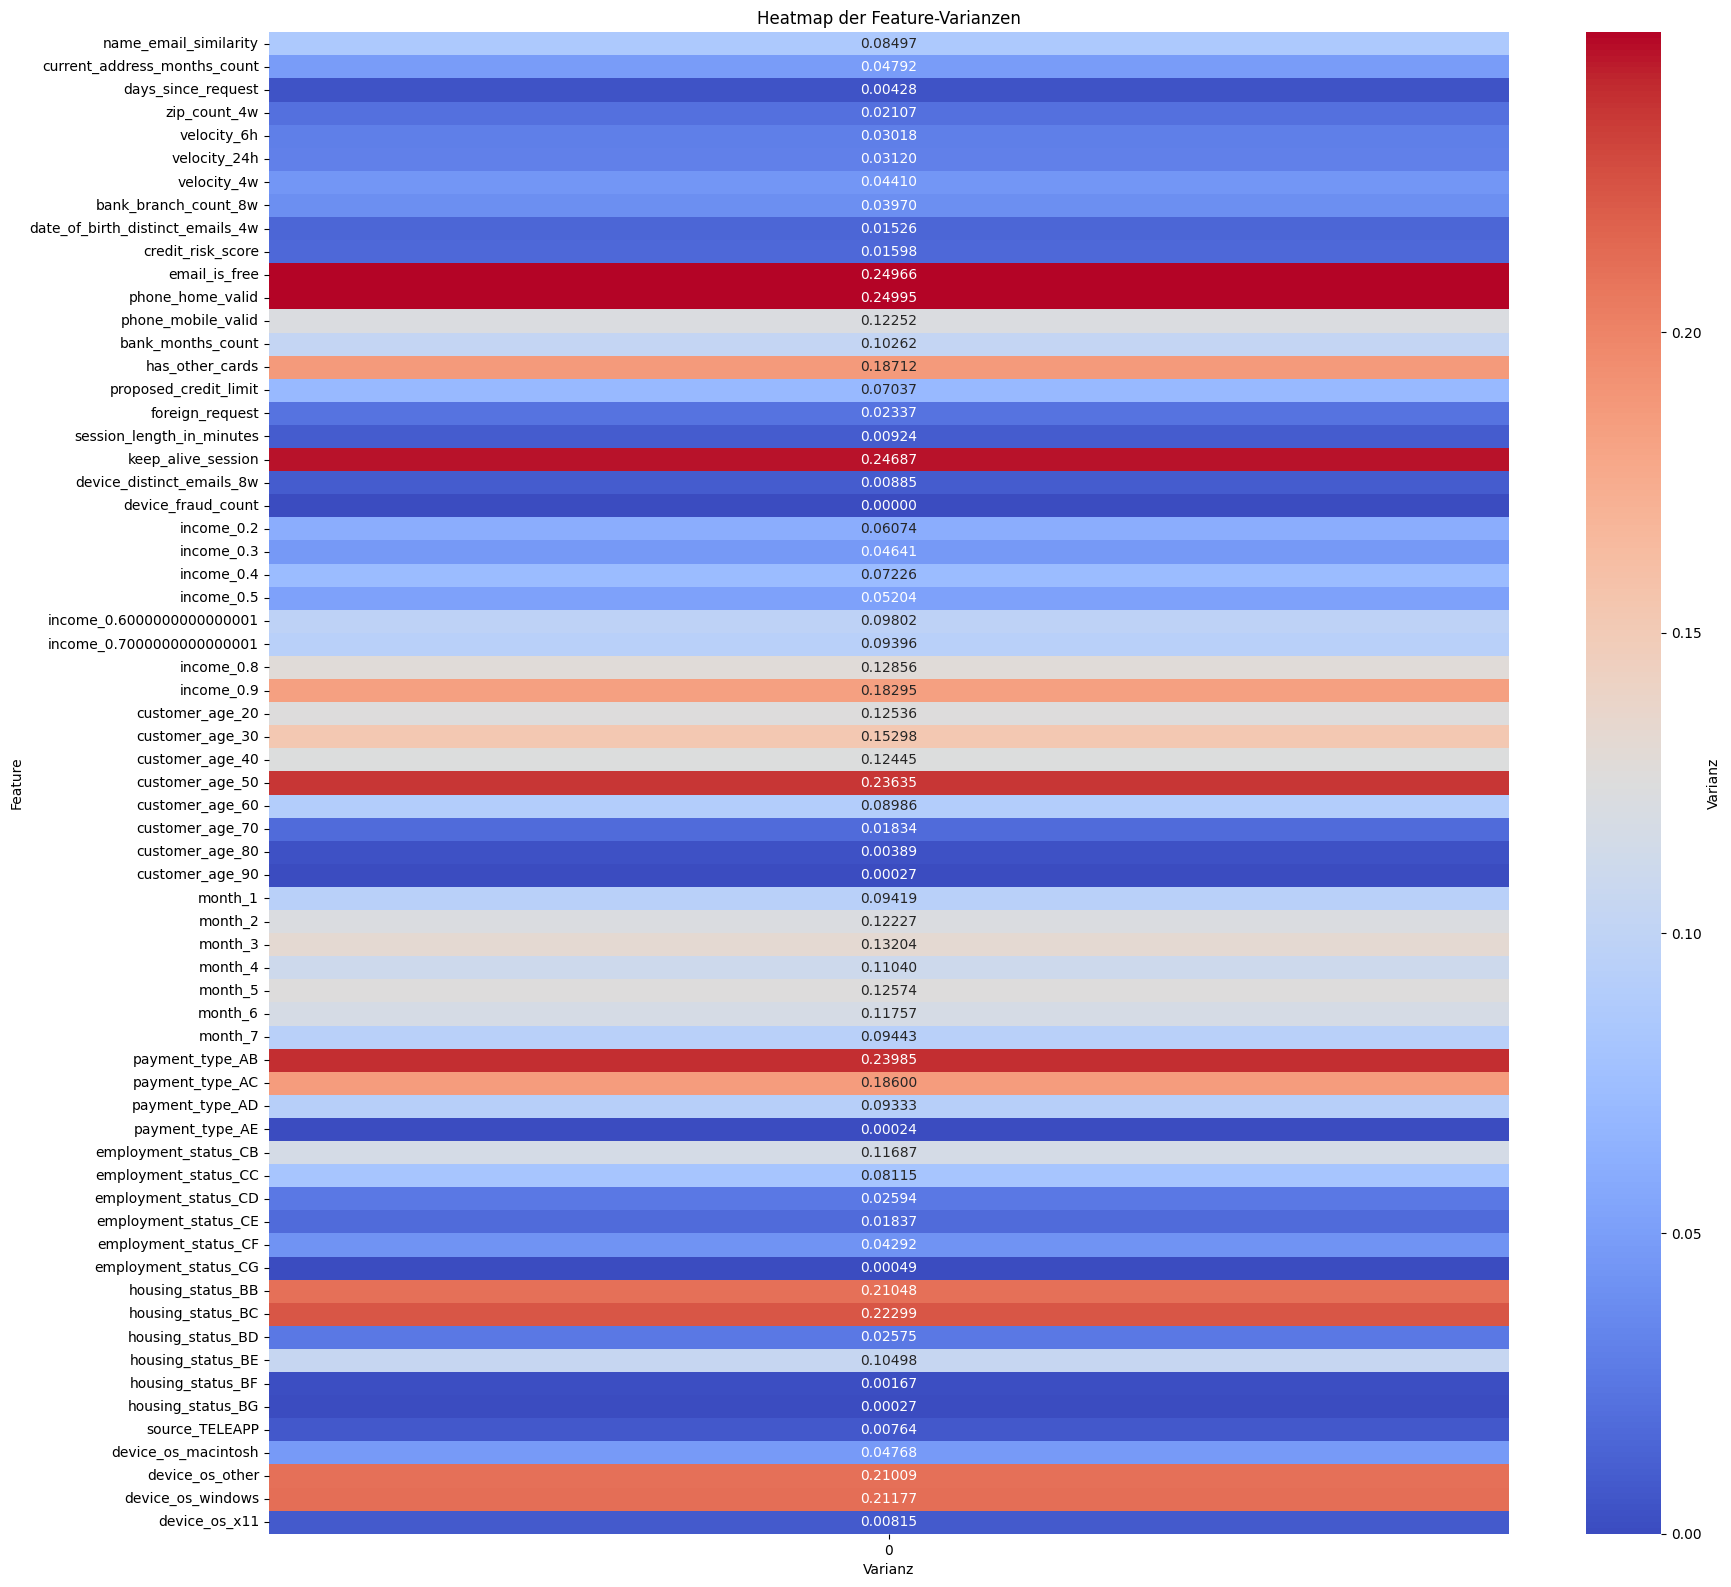

In [20]:
# Varianz aller Feature berechnen
variances = X.var()

# Als Heatmap darstellen
plt.figure(figsize=(20, len(X.columns)*0.3))  # Höhe abhängig von Anzahl Features
sns.heatmap(variances.to_frame(), annot=True, fmt=".5f", cmap="coolwarm", cbar_kws={'label': 'Varianz'}) # annot = True schreibt Werte in die Kästchen, 
# fmt=".5f" zeigt Werte im Heatmap nur bis 5 Dezimalstellen für bessere Lesbarkeit an
# cbar_kws={'label': 'Varianz'} labeled die Skala rechts

plt.title("Heatmap der Feature-Varianzen")
plt.xlabel("Varianz")
plt.ylabel("Feature")
plt.show()

In [27]:
# Automatisierte Varianzerkennung mit VarianceThreshold: Entfernt Features, deren Varianz unter einem Schwellwert liegt
sel = VarianceThreshold(threshold=0.01)  # Nur filter für die Daten, z. B. 0.01 = 1% Varianz, bedeutet es werden alle Spalten entfernt, bei denen eine Klasse 99% vorkommt
sel.fit_transform(X) # berechnet die Varianz jedes Features im data frame, verändert Daten nicht

# gibt behaltene Spalten aus
kept_columns = X.columns[sel.get_support()]

# gibt gelöschte Spalten aus
removed_columns = X.columns[~sel.get_support()]

#speichert die behaltenen Feature über Threshold in DataFrame
X = X[kept_columns]

#print("Behaltene Spalten (über Threshold):")
#print(list(kept_columns))

print("\n Entfernte Spalten (unter Threshold):")
print(list(removed_columns))


 Entfernte Spalten (unter Threshold):
['days_since_request', 'session_length_in_minutes', 'device_distinct_emails_8w', 'device_fraud_count', 'customer_age_80', 'customer_age_90', 'payment_type_AE', 'employment_status_CG', 'housing_status_BF', 'housing_status_BG', 'source_TELEAPP', 'device_os_x11']


In [42]:
# Zuerst 10% der Daten ziehen (stratifiziert nach y)
X_small, _, y_small, _ = train_test_split(
    X, y, train_size=0.1, stratify=y, random_state=42
)

# Dann normalen Train/Test Split innerhalb der 10%
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.3,       # 30% Test innerhalb der 10%
    stratify=y_small,    # Klassenverteilung bleibt erhalten
    random_state=42
)

# Aufteilen der Daten in Train und Testdaten
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y)
# stratify=y sorgt dafür, dass die Anteile der Klassen in y im Trainings- und Testset gleich bleiben. 0: 98.897% und 1: 1.103% in train und test-Daten.
# Bei stark unbalancierten Daten mit geringer Wahrscheinlichkeit einer Klasse wichtig, ohne stratify=y könnte es zufällig passieren, dass im Testset gar keine oder nur sehr wenige Klasse 1 ennthalten sind

In [28]:
# Aufteilen der Daten in Train und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y)
# stratify=y sorgt dafür, dass die Anteile der Klassen in y im Trainings- und Testset gleich bleiben. 0: 98.897% und 1: 1.103% in train und test-Daten.
# Bei stark unbalancierten Daten mit geringer Wahrscheinlichkeit einer Klasse wichtig, ohne stratify=y könnte es zufällig passieren, dass im Testset gar keine oder nur sehr wenige Klasse 1 ennthalten sind

In [43]:
RANDOM_STATE = 42

# scale_pos_weight für XGBoost/LightGBM = (#neg)/(#pos) für die beste Gewichtung
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
scale_pos_weight = n_neg / max(1, n_pos)
print("scale_pos_weight (neg/pos):", scale_pos_weight)

scale_pos_weight (neg/pos): 89.67357512953367


In [46]:
classes = np.unique(y_train)
cls_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {c: w for c, w in zip(classes, cls_weights)}

In [49]:
RANDOM_STATE = 42

# CV und Scoring
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = "average_precision"  # primär; z. B. "roc_auc" oder "precision" möglich

# Modelle + Grids (Pipeline nur mit Klassifier)
models_and_grids = {
    "DecisionTree": {
        "estimator": Pipeline([
            ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
        ]),
        "param_grid": {
            "clf__criterion": ["gini", "entropy"],
            "clf__max_depth": [5, 10, 20, None],
            "clf__min_samples_leaf": [1, 5, 20],
            "clf__class_weight": [None, "balanced", class_weight_dict]
        }
    },
    #"RandomForest": {
        #"estimator": Pipeline([
         #   ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
        #]),
        #"param_grid": {
         #   "clf__n_estimators": [100, 300],
          #  "clf__max_depth": [10, 20, None],
           # "clf__min_samples_leaf": [1, 5, 10],
            #"clf__class_weight": [None, "balanced", "balanced_subsample"]
        #}
    #},
    "GradientBoosting": {
        "estimator": Pipeline([
            ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
        ]),
        "param_grid": {
            "clf__n_estimators": [100, 300],
            "clf__learning_rate": [0.05, 0.1],
            "clf__max_depth": [3, 6],
            "clf__min_samples_leaf": [1, 5]
        }
    },
    "XGBoost": {
        "estimator": Pipeline([
            ("clf", xgb.XGBClassifier(
                random_state=RANDOM_STATE,
                use_label_encoder=False,
                eval_metric="logloss",
                n_jobs=-1
            ))
        ]),
        "param_grid": {
            "clf__n_estimators": [100, 300],
            "clf__max_depth": [3, 6],
            "clf__learning_rate": [0.05, 0.1],
            "clf__scale_pos_weight": [scale_pos_weight, 1.0]
        }
    },
    "LightGBM": {
        "estimator": Pipeline([
            ("clf", LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1))
        ]),
        "param_grid": {
            "clf__n_estimators": [100, 300],
            "clf__num_leaves": [31, 64],
            "clf__max_depth": [-1, 10, 20],
            "clf__learning_rate": [0.05, 0.1],
            "clf__scale_pos_weight": [scale_pos_weight, 1.0]
        }
    }
}

# Funktion für GridSearch + Evaluation
def run_grid_and_eval(name, estimator, param_grid, X_train, y_train, X_test, y_test):
    print("\n\n==========", name, "==========")
    model_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        verbose=1,
        refit=True
    )
    model_search.fit(X_train, y_train)
    print("Best Params:", model_search.best_params_)
    print("Best CV ({}): {:.4f}".format(scoring, model_search.best_score_))
    
    best = model_search.best_estimator_
    y_pred = best.predict(X_test)
    y_proba = None
    if hasattr(best, "predict_proba"):
        y_proba = best.predict_proba(X_test)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:\n", cm)
    tn, fp, fn, tp = cm.ravel()
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    rocauc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print("\nPrecision (pos): {:.4f}".format(precision))
    print("Recall (pos): {:.4f}".format(recall))
    print("F1 (pos): {:.4f}".format(f1))
    if rocauc is not None:
        print("ROC-AUC: {:.4f}".format(rocauc))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4, zero_division=0))
    
    return model_search, {"precision": precision, "recall": recall, "f1": f1, "roc_auc": rocauc, "cm": cm}

# Alles ausführen
results = {}
for name, cfg in models_and_grids.items():
    gs, metrics = run_grid_and_eval(name, cfg["estimator"], cfg["param_grid"], X_train, y_train, X_test, y_test)
    results[name] = {"gridsearch": gs, "metrics": metrics}

# Kurz-Zusammenfassung
summary = {name: { "f1": results[name]["metrics"]["f1"],
                   "precision": results[name]["metrics"]["precision"],
                   "recall": results[name]["metrics"]["recall"],
                   "roc_auc": results[name]["metrics"]["roc_auc"] } 
           for name in results}

print("\n\n=== Kurz Übersicht (Test) ===")
for k, v in summary.items():
    print(f"{k:12} -> F1: {v['f1']:.4f}, Precision: {v['precision']:.4f}, Recall: {v['recall']:.4f}, ROC-AUC: {v['roc_auc']}")



========== DecisionTree ==========
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Params: {'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 20}
Best CV (average_precision): 0.0583

Confusion Matrix:
 [[29661     8]
 [  329     2]]
TN=29661, FP=8, FN=329, TP=2

Precision (pos): 0.2000
Recall (pos): 0.0060
F1 (pos): 0.0117
ROC-AUC: 0.7542

Classification Report:
               precision    recall  f1-score   support

           0     0.9890    0.9997    0.9944     29669
           1     0.2000    0.0060    0.0117       331

    accuracy                         0.9888     30000
   macro avg     0.5945    0.5029    0.5030     30000
weighted avg     0.9803    0.9888    0.9835     30000



========== GradientBoosting ==========
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Params: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 300}
Best CV (averag

C:\Users\MLA6FE\.conda\envs\graduate\lib\site-packages\xgboost\training.py:199: UserWarning: [12:39:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Params: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 300, 'clf__scale_pos_weight': 1.0}
Best CV (average_precision): 0.1253

Confusion Matrix:
 [[29661     8]
 [  326     5]]
TN=29661, FP=8, FN=326, TP=5

Precision (pos): 0.3846
Recall (pos): 0.0151
F1 (pos): 0.0291
ROC-AUC: 0.8720

Classification Report:
               precision    recall  f1-score   support

           0     0.9891    0.9997    0.9944     29669
           1     0.3846    0.0151    0.0291       331

    accuracy                         0.9889     30000
   macro avg     0.6869    0.5074    0.5117     30000
weighted avg     0.9825    0.9889    0.9838     30000



========== LightGBM ==========
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LightGBM] [Info] Number of positive: 772, number of negative: 69228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if m

In [22]:


# Vorbereitung der Daten mit Pipeline, eine Pipeline kann für sehr viele Modelle genutzt werden und arbeitet die verschiedenen Schritte ab

#rus = RandomUnderSampler(sampling_strategy='minority', random_state=42)

pipe_log = Pipeline([
    #("undersample", rus),
    #("smote", None), # noch besser als SMOTE für unser Problem, erzeugt synthetische Samples die nahe an der KlassenGrenze liegen. WIrd automatisch nur auf Minderheitsklasse angewandt
    #("smote", SMOTE(random_state=42)), # vor dem Model aufrufen, Oversamping, erzeugt neue Datenpunke der Minderheitsklasse nur k-Neighbours, sodass gleich viele Daten von 0 und 1 vorhanden sind
    # immer nur nach dem split nur auf Trainiingsdaten, WIrd automatisch nur auf Minderheitsklasse angewandt, danach gleiche Größe wie Mehrheitsklasse
    # Benötigt zusätzlichen learn.pipeline import Pipeline für spezielle SMOTE pipeline
    # Bestimmung der Funktion, ob Polynome Features eingeführt werden sollen (eher für kleine Datensätze)
    #('preprocessing', PolynomialFeatures(2)), 
    # Bestimmung des Modells, penalty = "l2" ist standard und steht für Ridge-Regularisierung
    # die Regularisierung führt einen Strafterm ein mit lambda, sodass es zu keinen Übergewichtungen von parametern kommt
    # C (=1/lambda) bestimmt die Gesichtung des Strafterms, default ist hier 1.0
    # max_iter bestimmt wie viele Iterationen zur Optimierung des Modells durchgeführt werden
    #("scaler", MinMaxScaler()),
    ("model", None)
    ])

grid_search = {
    "model": [xgb.XGBClassifier()],
    "model__n_estimators": [100], # Anzahl der Bäume
    "model__max_depth": [3], # maximale Tiefe eines Baumes
    "model__scale_pos_weight": [scale_pos_weight], # Gewichtung der Minderheitsklasse, typisch Anzahl Negativwerte/Anzahl Positivwerte (98,897/1,103 = 89,67 in diesem Fall)
    #"model__reg_lambda": [1] # Regularisation wie bei Ridge, Strafterm
    #"model__eval_metric": ["logloss"]
}

# l1 für Lasso: Setzt manche Feature direkt auf 0 und entfernt sie somit, automatische Feature Selektion, starke Feature bleiben, schwache werden gelöscht
# l2 für Ridge: Strafterm für Koeffizienten, große Koeffizienten werden mehr bestraft, alle Koeffizienten werden kleiner, keiner wird exakt 0, starke Features bleiben, schwache werden reduziert

#erhält im Gegensatz zu kFold die die Klassenverteilung in jedem Fold, also proportional wie im gesamten Datensatz.(also wie bei stratify=y, nur für alle 5 cvs)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



model_grid = GridSearchCV(
    pipe_log,
    grid_search,
    cv = cv, # macht 5 cross validation splits
    scoring = "average_precision"
)

# scoring

#0    98.897
#1     1.103

#ROC Kurve

# Fit der Daten mit den Traindaten
#pipe.fit(X_train, y_train)

In [37]:
model_grid.fit(X_train.values, y_train.values)

,estimator,Pipeline(step..._iter=1000))])
,param_grid,{'model__penalty': ['l2']}
,scoring,'average_precision'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


Wie sollte man das Modell validieren?
sehr ungleich verteilte Daten mit 

fraud_bool
0    98.897
1     1.103

Zahlentechnische Bewertung des Modells
1. Precision: Von allen Fällen, die das Modell als „positiv“ vorhergesagt hat, wie viele waren wirklich positiv? Benötigt dazu 0/1 Werte der Minderheitsklasse.
2. Recall: Von allen echten positiven Fällen – wie viele erkennt das Modell? Benötigt dazu 0/1 Werte der Minderheitsklasse.
3. Average Precision: Wie gut ist mein Modell über alle Thresholds hinweg in Bezug auf Precision & Recall? Benötigt dazu Wahrscheinlichkeiten Werte der Minderheitsklasse.
4. F1-Score: harmonisches Mittel aus Precision und Recall. Der Score sagt voraus, wie gut das Modell gleichzeitig Precision und Recall erfüllt – also wie zuverlässig und wie vollständig
   dein Modell die positive Klasse erkennt. Benötigt dazu 0/1 Werte der Minderheitsklasse. Sehr gut bei stark unterschiedlichen Klassen

Grafische Bewertung und Ableitung
1: ROC-Kurve (Receiver Operating Characteristic)
Achsen:
x-Achse: False Positive Rate (FPR) = FP / (FP + TN)
y-Achse: True Positive Rate (TPR = Recall) = TP / (TP + FN)
Interpretation:
Zeigt die Leistung des Modells über alle möglichen Schwellenwerte
ROC-AUC = Fläche unter der ROC-Kurve
Werte: 0.5 = zufällig, 1 = perfekt
Problem bei unbalancierten Daten:
Wenn die negative Klasse sehr dominant ist, kann die FPR klein bleiben, selbst wenn das Modell viele Positive übersieht → ROC-AUC sieht „gut“ aus, obwohl das Modell die seltene Klasse schlecht erkennt.
--> In diesem Fall vermutlich nicht so geeignet da die negative Klasse stark überweigt

2: Precision-Recall-Kurve (PR-Kurve)
Achsen:
x-Achse: Recall (TP / (TP + FN))
y-Achse: Precision (TP / (TP + FP))
Interpretation:
Fokus liegt nur auf der positiven (seltenen) Klasse
Zeigt, wie präzise und vollständig die Vorhersagen der seltenen Klasse sind
Average Precision = Fläche unter der PR-Kurve
Vorteil bei unbalancierten Daten:
PR-Kurve verschafft einen realistischen Blick auf die Modellleistung bei seltenen Ereignissen (z. B. Betrug, Krankheit).

3. F1 score über Threshold
Achsen:
x-Achse: Threshold (Schwellwert), meist 0.0 → 1.0
y-Achse: F1-Score
Interpretation:
Wie gut das Modell die positive Klasse (Klasse 1) erkennt – abhängig vom gewählten Threshold.
Bei niedrigen Thresholds (z. B. 0.05):
→ Modell sagt oft „positiv“ → hoher Recall, niedrige Precision → F1 kann steigen/fallen
Bei hohen Thresholds (z. B. 0.9):
→ Modell sagt kaum „positiv“ → hoher Precision, niedriger Recall → F1 sinkt fast immer
Die Kurve hat meistens einen klaren Peak, der den besten Kompromiss zwischen Precision und Recall zeigt und somit den optimalen F1-Score liefert.
0.7–1.0 = gut
<0.3 = sehr schlecht

Bei diesem Problem sit eine Bewertung auf average_precision am sinnvollsten und f1 zur Thresholdoptimierung

In [38]:
# gibt die 5 besten Ergebnisse der Parametervariation aus
nr_best = 5

mean_test_score = model_grid.cv_results_['mean_test_score']
params = model_grid.cv_results_['params']

best_scores_args = np.argsort(mean_test_score)[::-1][:nr_best]

print(f'The {nr_best} best classification results\n')
for i in best_scores_args:
    print(f'{100*mean_test_score[i]:.2f}  {params[i]}')

The 5 best classification results

11.70  {'model__penalty': 'l2'}


In [39]:
# Abrufen der besten Parametervariation aus dem fit
model_grid.best_params_

{'model__penalty': 'l2'}

## Precision-Recall Kurve vs. Threshold anzeigen, um evtl. besseren Threshold zu bestimmen

C:\Users\MLA6FE\.conda\envs\graduate\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


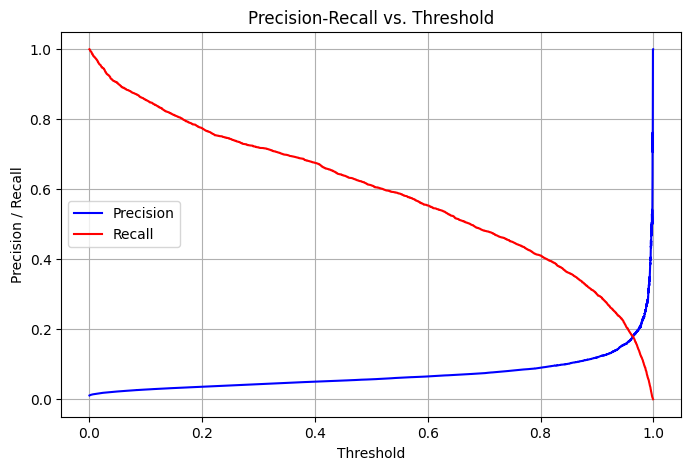

In [40]:
# Präzision: Von allen Fällen, die das Modell als positiv vorhergesagt hat, wie viele sind tatsächlich positiv?
# Recall: Von allen tatsächlich positiven Fällen, wie viele erkennt das Modell korrekt?

# Wahrscheinlichkeiten für Klasse 1
y_pred_prob = model_grid.predict_proba(X_test)[:, 1] # gibt nur Wahrscheinlichkeit der positiven Klasse zurück (1)

# Precision, Recall und Thresholds berechnen
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# thresholds hat N-1 Elemente, precision & recall N → deshalb [:-1] benutzen
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue') # threshold ist imemr eins kürzer als precision oder recall auf Grund der Brechnung von precision und recall n+1
# letzten Wert von precision und recall abziehen für gleiche Länge, sonst Fehler
plt.plot(thresholds, recall[:-1], label='Recall', color='red')
plt.xlabel('Threshold')
plt.ylabel('Precision / Recall')
plt.title('Precision-Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# der Schnittpunkt ist der F1-Score mit bestem Verhältnis von Precision und Recall, hier lässt sich auch der zugehörige Threshold ablesen

## Precision-Recall Kurve anzeigen, um zu sehen wie gut das Modell ist

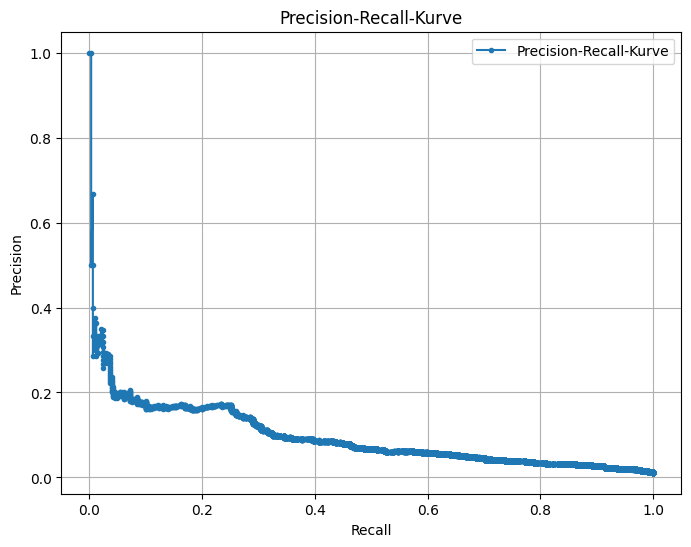

In [101]:
# Präzision: Von allen Fällen, die das Modell als positiv vorhergesagt hat, wie viele sind tatsächlich positiv?
# Recall: Von allen tatsächlich positiven Fällen, wie viele erkennt das Modell korrekt?
# "average_precision" ist die Fläche unter der Kurve: 1 = perfektes Modell, das alle Positiven erkennt ohne False Positives, 0.5 = zufälliges Modell (nur grob bei stark unausgeglichenen Klassen).

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

# Plot
plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label='Precision-Recall-Kurve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall-Kurve')
plt.legend()
plt.grid(True)
plt.show()

## F1-Kurve, um Theshold für maximalen F1-Wert zu ermitteln

C:\Users\MLA6FE\.conda\envs\graduate\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Bester Threshold: 0.9400000000000001
Bester F1-Score: 0.1820721769499418


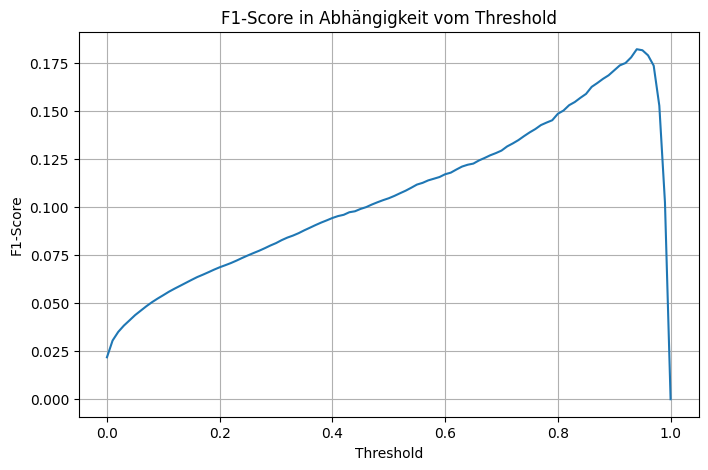

In [41]:
# Wahrscheinlichkeiten holen für die positive Klasse 1
y_proba = model_grid.predict_proba(X_test)[:, 1]

# Theshold von 0-1 testen
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred))

# Besten Threshold bestimmen
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print("Bester Threshold:", best_threshold)
print("Bester F1-Score:", best_f1)

# F1-Verlauf als Grafik
plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores)
plt.xlabel("Threshold")
plt.ylabel("F1-Score")
plt.title("F1-Score in Abhängigkeit vom Threshold")
plt.grid(True)
plt.show()

## Predictions/Vorhersagen ermitteln und ggf. Threshold anpassen

In [34]:
# Wahrscheinlichkeiten für die positive Klasse
probs_train = model_grid.predict_proba(X_train)[:, 1]
probs_test = model_grid.predict_proba(X_test)[:, 1]

# Eigenen Threshold anwenden, z.B. 0.3
threshold = 0.93 # standard Threshold beträgt 0.5 bei sigmoid function
y_train_predict = (probs_train >= threshold).astype(int) # wandelt Wahrscheinlichkeiten in 0 und 1 um mit definiertem threshold
y_test_predict = (probs_test >= threshold).astype(int) # wandelt Wahrscheinlichkeiten in 0 und 1 um mit definiertem threshold

# Test der Vorhersage mit den train-Daten
#y_train_predict = random_search.predict(X_train) # wandelt Wahrscheinlichkeiten in 0 und 1 um mit Standard threshold von 0.5

# Test der Vorhersage mit den test-Daten
#y_test_predict = random_search.predict(X_test) # wandelt Wahrscheinlichkeiten in 0 und 1 um mit Standard threshold von 0.5

C:\Users\MLA6FE\.conda\envs\graduate\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\MLA6FE\.conda\envs\graduate\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## Sensitivity vs. Specificy (bei zuvor definiertem Threshold

C:\Users\MLA6FE\AppData\Local\Temp\ipykernel_23512\2595549708.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value', data=metrics_df, palette='Blues')


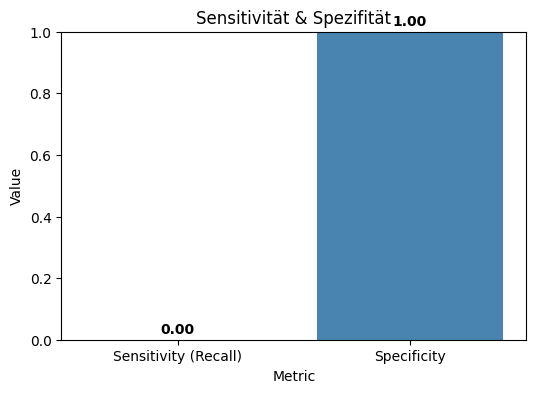

In [35]:
# Sensitivity (Sensitivität) = Wie gut erkennt das Modell die Positiven (Betrug / Fälle / 1er)
# Beispiel bei 79 %: Von allen tatsächlich positiven Fällen werden 79 % vom Modell richtig erkannt, 21 % übersieht das Modell und sind damit falsch negativ
# Specificity (Spezifität) = Wie gut erkennt das Modell die Negativen (Nicht-Betrug / Nicht-Fälle / 0er)
# Beispiel bei 82 %: Von allen tatsächlich negativen Fällen werden 82 % vom Modell richtig erkannt, 18 % werden vom Modell falsch positiv eingestuft

# y_test = wahre Labels
# y_test_predict = Vorhersagen (0/1)

# berechnet die confusion Matrix und speichert die Werte true negative, false positive, false negative und true positive in Variablen
cm = confusion_matrix(y_test, y_test_predict)
tn, fp, fn, tp = cm.ravel()

# Berechnung der sensitivity und specificity
sensitivity = tp / (tp + fn)   # Recall
specificity = tn / (tn + fp)

# Speichern in einem DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['Sensitivity (Recall)', 'Specificity'],
    'Value': [sensitivity, specificity]
})

# Darstellung als Plot
plt.figure(figsize=(6,4))
sns.barplot(x='Metric', y='Value', data=metrics_df, palette='Blues')
plt.ylim(0, 1)
plt.title('Sensitivität & Spezifität')
for i, v in enumerate(metrics_df['Value']):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

## Confusion Matrix und Classification Report für Train-Daten

Average Precision score: 0.24904330775857675
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     69228
           1       0.34      0.23      0.28       772

    accuracy                           0.99     70000
   macro avg       0.67      0.61      0.63     70000
weighted avg       0.98      0.99      0.99     70000



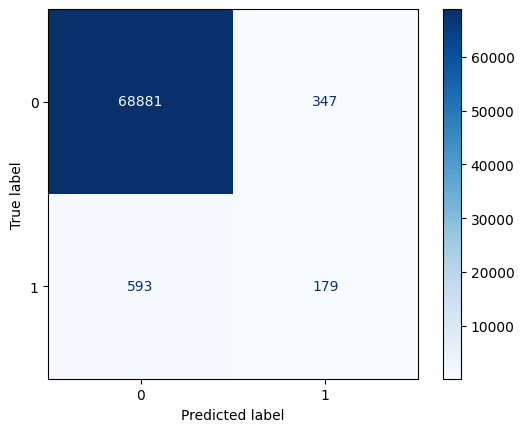

In [104]:
# Erstellen der Confusion Matrix für train-Daten
cm = confusion_matrix(y_train, y_train_predict)
plotted_matrix = ConfusionMatrixDisplay(confusion_matrix= cm)
plotted_matrix.plot(cmap='Blues')
y_train_scores = model_grid.predict_proba(X_train)[:, 1]
#print("Precision score:", precision_score(y_train, y_train_predict)) # precision score braucht 0/1 prediction
#print("Recall score:", recall_score(y_train, y_train_predict)) # recall score braucht 0/1 prediction
#print("F1 score:", f1_score(y_train, y_train_predict)) # f1 score braucht 0/1 prediction
print("Average Precision score:", average_precision_score(y_train, y_train_scores)) # average precision braucht y_test_scores = random_search.predict_proba(X_train)[:,1], kann mit 0/1 nicht arbeiten. 
#gibt Wert zwischne 0 und 1 aus, 1 sehr gute Präzision, 0 serh schlecht
print(classification_report(y_train, y_train_predict)) # der classification report stellt precision, recall, f1-score und support für alle Klassen dar

## Confusion Matrix und Classification Report für Test-Daten

Average Precision score: 0.09731560038227695
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     29669
           1       0.16      0.11      0.13       331

    accuracy                           0.98     30000
   macro avg       0.58      0.55      0.56     30000
weighted avg       0.98      0.98      0.98     30000



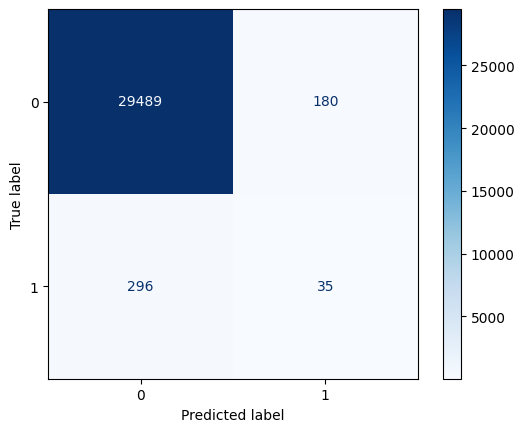

In [105]:
# Erstellen der Confusion Matrix für test-Daten
cm = confusion_matrix(y_test, y_test_predict)
plotted_matrix = ConfusionMatrixDisplay(confusion_matrix= cm)
plotted_matrix.plot(cmap='Blues')
y_test_scores = model_grid.predict_proba(X_test)[:, 1]
#print("Precision score:", precision_score(y_test, y_test_predict)) # precision score braucht 0/1 prediction
#print("Recall score:", recall_score(y_test, y_test_predict)) # recall score braucht 0/1 prediction
#print("F1 score:", f1_score(y_test, y_test_predict)) # f1 score braucht 0/1 prediction
print("Average Precision score:", average_precision_score(y_test, y_test_scores)) # average precision braucht y_test_scores = random_search.predict_proba(X_train)[:,1], kann mit 0/1 nicht arbeiten. 
#gibt Wert zwischne 0 und 1 aus, 1 sehr gute Präzision, 0 serh schlecht
print(classification_report(y_test, y_test_predict)) # der classification report stellt precision, recall, f1-score und support für alle Klassen dar

In [ ]:
grid_search = {
    "model": [xgb.XGBClassifier()],
    "model__n_estimators": [100], # Anzahl der Bäume
    "model__max_depth": [3], # maximale Tiefe eines Baumes
    "model__scale_pos_weight": [89], # Gewichtung der Minderheitsklasse, typisch Anzahl Negativwerte/Anzahl Positivwerte (98,897/1,103 = 89 in diesem Fall)
    #"model__reg_lambda": [1] # Regularisation wie bei Ridge, Strafterm
    #"model__eval_metric": ["logloss"]
}


In [ ]:
grid_search = [{
    "model": [RandomForestClassifier()],
    "model__n_estimators": [100], # Anzahl der Bäume
    "model__max_depth": [3], # maximale Tiefe eines Baumes
    "model__class_weight": ["balanced"] # Klassengewichtung
},

{
    "model": [GradientBoostingClassifier()],
    "model__n_estimators": [100], # Anzahl der Bäume
    "model__max_depth": [3] # maximale Tiefe eines Baumes
},
    
    {
    "model": [xgb.XGBClassifier()],
    "model__n_estimators": [100], # Anzahl der Bäume
    "model__max_depth": [3], # maximale Tiefe eines Baumes
    "model__scale_pos_weight": [89], # Gewichtung der Minderheitsklasse, typisch Anzahl Negativwerte/Anzahl Positivwerte (98,897/1,103 in diesem Fall)
    "model__reg_lambda": [1] # Regularisation wie bei Ridge, Strafterm
    #"model__eval_metric": ["logloss"]
}]


In [36]:
# Vorbereitung der Daten mit Pipeline, eine Pipeline kann für sehr viele Modelle genutzt werden und arbeitet die verschiedenen Schritte ab
pipe_log = Pipeline([
    ('smote', BorderlineSMOTE(random_state=42)), # noch besser als SMOTE für unser Problem, erzeugt synthetische Samples die nahe an der KlassenGrenze liegen. WIrd automatisch nur auf Minderheitsklasse angewandt
    #("smote", SMOTE(random_state=42)), # vor dem Model aufrufen, Oversamping, erzeugt neue Datenpunke der Minderheitsklasse nur k-Neighbours, sodass gleich viele Daten von 0 und 1 vorhanden sind
    # immer nur nach dem split nur auf Trainiingsdaten, WIrd automatisch nur auf Minderheitsklasse angewandt, danach gleiche Größe wie Mehrheitsklasse
    # Benötigt zusätzlichen learn.pipeline import Pipeline für spezielle SMOTE pipeline
    # Bestimmung der Funktion, ob Polynome Features eingeführt werden sollen (eher für kleine Datensätze)
    #('preprocessing', PolynomialFeatures(2)), 
    # Bestimmung des Modells, penalty = "l2" ist standard und steht für Ridge-Regularisierung
    # die Regularisierung führt einen Strafterm ein mit lambda, sodass es zu keinen Übergewichtungen von parametern kommt
    # C (=1/lambda) bestimmt die Gesichtung des Strafterms, default ist hier 1.0
    # max_iter bestimmt wie viele Iterationen zur Optimierung des Modells durchgeführt werden
    ("model", LogisticRegression(max_iter=1000))
    ])

grid_search = {
    #"preprocessing__degree": [2, 3],
    "model__penalty": ["l2"], # Regularisierung, l1 für Lasso und l2 für Ridge
    #"model__solver": ["liblinear", "saga"],
    #"model__l1_ratio": [0.5],  # nötig für elasticnet
    #"model__class_weight": ["balanced", {0:1, 1:5}], # gewichtet Klassen anders, jede 0 zählt normal mit Gewicht 1 und jede 1 zählt 5 mal so stark, ist eher trial and error
    # balanced: automatische Anpassung der Gewichte an die Klassenhäufigkeit, jede Klasse bekommt ein Gewicht umgekehrt proportional zu ihrer Häufigkeit, setzt Gewicht für Fraud hoch und für Fraud nicht runter
    #"model__C": [0.01, 0.1, 10]
}

# l1 für Lasso: Setzt manche Feature direkt auf 0 und entfernt sie somit, automatische Feature Selektion, starke Feature bleiben, schwache werden gelöscht
# l2 für Ridge: Strafterm für Koeffizienten, große Koeffizienten werden mehr bestraft, alle Koeffizienten werden kleiner, keiner wird exakt 0, starke Features bleiben, schwache werden reduziert

#erhält im Gegensatz zu kFold die die Klassenverteilung in jedem Fold, also proportional wie im gesamten Datensatz.(also wie bei stratify=y, nur für alle 5 cvs)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_grid = GridSearchCV(
    pipe_log,
    grid_search,
    cv = cv, # macht 5 cross validation splits
    scoring = "average_precision"
)
# scoring

# Fit der Daten mit den Traindaten
#pipe.fit(X_train, y_train)

In [ ]:
# Modellvalidierung mit statsmodel
train_endog = y_train # Zielvariable (abhängige Variable)
train_exog = sm.add_constant(X_train) # Erklärende Variablen (unabhängige Variable), sm.add_constant fügt Spalte mit nur Einsen hinzu für Intercept (β₀)

test_endog = y_test # Zielvariable (abhängige Variable)
test_exog = sm.add_constant(X_test) # Erklärende Variablen (unabhängige Variable), sm.add_constant fügt Spalte mit nur Einsen hinzu für Intercept (β₀)

# Model Training
logit_mod = sm.Logit(train_endog, train_exog)
logit_res = logit_mod.fit()

# Calculating probas
logit_probabilities = logit_res.predict(test_exog)
logit_predictions = pd.Series(logit_probabilities).apply(lambda x: 1 if (x > 0.5) else 0)

ConfusionMatrixDisplay.from_predictions(test_endog, logit_predictions)
from sklearn.metrics import accuracy_score
print(average_precision_score(test_endog, logit_predictions))

print(logit_res.summary())